# Modeling (Responsible: A)

a. Identify suitable data mining algorithms and select one of these as the most suitable for your
experiments, providing a justification for the selection.

b. Identify the hyper-parameters available for tuning in your chosen model and select one that
you deem most relevant for tuning, providing a justification.

c. Define and document a train / validation / test set split, considering where necessary
appropriate stratification, any dependencies between data instances (e.g. time series data)
and relative sizes of the respective subsets.

d. Train the model on the training set and compare the performance on the validation set to
identify the best hyper-parameter setting, explicitly documenting all parameter settings
tested (avoid stating simply to have used “default parameters”, focus on reproducibility of the
results you report). 

e. Report suitable performance metrics supported, where possible, by figures/graphs showing
the tuning process of the hyper parameter. 

## 4.a

For our data mining task we have chosen the following algorithms:

- Ordinary Least Squares (OLS)
- Stochastic Gradient Descent (SDG)
- Random Forest Regressor

All these three models are easy to understand and to implement and for large data samples as ours good to handle in a reasonable time.

Least Squares: Its a linear model with coefficients to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

Stochastic Gradient Descent: The gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both.

Random Forest: A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [84]:
#Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

#others
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pandas as pd
import numpy as np

pp = pprint.PrettyPrinter(indent=2, width=80, compact=True)

df = pd.read_csv('spotify_songs.csv')

df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxury Remix,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury Remix],2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


## 4.b

For our hyperparameter tuning, we opted for a computationally less intensive approach by using RandomizedSearchCV, which provides faster results. Previously, we had implemented GridSearchCV, but this method was too resource-intensive and failed to produce results within a reasonable runtime.

RandomizedSearchCV implements the fit and score methods. Additionally, it provides methods such as score_samples, predict, predict_proba, decision_function, transform, and inverse_transform, depending on the capabilities of the estimator used.

The parameters of the estimator are optimized through a cross-validated search over specified parameter distributions. Unlike GridSearchCV, which exhaustively evaluates all possible parameter combinations, RandomizedSearchCV samples a fixed number of parameter settings from the specified distributions. The number of settings to evaluate is determined by the n_iter parameter.

The best hyperparameters identified through this process, along with their corresponding values, will be stored and presented.

In [85]:
hyperparameter_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

hyperparameter_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0], # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'sparse_cg', 'sag', 'lsqr']
}

hyperparameter_grid_sgd = {
    'loss': ['squared_loss', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'optimal'],
    'eta0': [0.01, 0.1]
}

### For faster results, we use a subsampled data

In [86]:
df_sample = df.sample(n=1000, random_state=42)

## helper function


In [87]:
columns_to_drop = [
    'track_id', 'track_name', 'track_artist',
    'track_album_id', 'track_album_name',
    'playlist_id', 'playlist_name'
]
scale_features = ['duration_ms', 'tempo']
categorical_features = ['playlist_genre', 'playlist_subgenre']

def preprocess_features(X):
    # Convert release date to datetime and extract the year
    X = X.copy()
    X['track_album_release_date'] = pd.to_datetime(
        X['track_album_release_date'], format='ISO8601', errors='coerce'
    )
    X['album_release_year'] = X['track_album_release_date'].dt.year
    X = X.drop(columns=['track_album_release_date'])
    
    # Drop unnecessary columns
    X = X.drop(columns=columns_to_drop)
    X = X.dropna()
    
    return X

## 4.c 

### Train, Test and Validation Split

The dataset is split in two steps: first into a train-validation set and a test set, and then further into separate train and validation sets. Before splitting the data, the target variable is removed to isolate the features for preprocessing.

During preprocessing, several steps are performed to prepare the data for modeling:
	1.	Handling Missing Values: Rows containing missing data are removed to ensure data consistency.
	2.	Date Conversion and Feature Extraction: The release date of tracks is converted into a datetime format, and the release year is extracted as a new feature. This allows the model to utilize temporal information effectively.
	3.	Dropping Irrelevant Columns: Columns that are not relevant for model training, such as IDs, track names, and playlist names, are removed to avoid unnecessary noise in the dataset.

These preprocessing steps are applied separately to the train, validation, and test sets to maintain consistency while preventing any information from one set leaking into another, therefore preventing data leakage.


In [88]:
# Separate features and target
X = df.drop("track_popularity", axis=1)
y = df["track_popularity"]

# Split data into train+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)


X_train = preprocess_features(X_train)
X_val = preprocess_features(X_val)
X_test = preprocess_features(X_test)

y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

#column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_features),
        ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_transformed = column_transformer.fit_transform(X_train)

X_val_transformed = column_transformer.transform(X_val)
X_test_transformed = column_transformer.transform(X_test)

results_list = []

# Random Forest

In [89]:
# Initialize the model
rf = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyperparameter_grid_rf,
    n_iter=2, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

# Fit on the training data
random_search_rf.fit(X_train_transformed, y_train)

# Best model evaluation on validation set
best_rf = random_search_rf.best_estimator_
val_predictions_rf = best_rf.predict(X_val_transformed)
mse_rf = mean_squared_error(y_val, val_predictions_rf)
mae_rf = mean_absolute_error(y_val, val_predictions_rf)
r2_rf = r2_score(y_val, val_predictions_rf)

# Format best parameters
best_params_rf = pp.pformat(random_search_rf.best_params_)

# Append results to the list
results_list.append({
    "Model": "Random Forest Regressor",
    "MSE": mse_rf,
    "MAE": mae_rf,
    "R2 Score": r2_rf,
    "Best Parameters": best_params_rf
})

Fitting 3 folds for each of 2 candidates, totalling 6 fits


# Ridge Regression

In [90]:
ridge = Ridge(random_state=42)

# Set up RandomizedSearchCV
random_search_ridge = RandomizedSearchCV(
    estimator=ridge,
    param_distributions=hyperparameter_grid_ridge,
    n_iter=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

random_search_ridge.fit(X_train_transformed, y_train)

best_ridge = random_search_ridge.best_estimator_
val_predictions_ridge = best_ridge.predict(X_val_transformed)
mse_ridge = mean_squared_error(y_val, val_predictions_ridge)
mae_ridge = mean_absolute_error(y_val, val_predictions_ridge)
r2_ridge = r2_score(y_val, val_predictions_ridge)

results_list.append({
    "Model": "Ridge Regression",
    "MSE": mse_ridge,
    "MAE": mae_ridge,
    "R2 Score": r2_ridge,
    "Best Parameters": pp.pformat(random_search_ridge.best_params_)
})

Fitting 3 folds for each of 5 candidates, totalling 15 fits


# Stochastic Gradient Descent

In [91]:
sgd = SGDRegressor(random_state=42, max_iter=1000)

random_search_sgd = RandomizedSearchCV(
    estimator=sgd,
    param_distributions=hyperparameter_grid_sgd,
    n_iter=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

random_search_sgd.fit(X_train_transformed, y_train)

# Best model evaluation on validation set
best_sgd = random_search_sgd.best_estimator_
val_predictions_sgd = best_sgd.predict(X_val_transformed)
mse_sgd = mean_squared_error(y_val, val_predictions_sgd)
mae_sgd = mean_absolute_error(y_val, val_predictions_sgd)
r2_sgd = r2_score(y_val, val_predictions_sgd)

# Format best parameters
best_params_sgd = pp.pformat(random_search_sgd.best_params_)

results_list.append({
    "Model": "SGD Regressor",
    "MSE": mse_sgd,
    "MAE": mae_sgd,
    "R2 Score": r2_sgd,
    "Best Parameters": best_params_sgd
})

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/Caskroom/miniconda/base/envs/businessintelligence/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/businessintelligence/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/businessintelligence/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/Caskroom/minicon

## 4.d & 4.e

## Results and Graphs

In [92]:
results_df = pd.DataFrame(results_list)

results_df = results_df[[
    "Model", "MSE", "MAE", "R2 Score", "Best Parameters"
]]

pd.set_option('display.max_colwidth', None)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                     Model          MSE        MAE  R2 Score  \
0  Random Forest Regressor   423.761535  16.630657   0.31979   
1         Ridge Regression   522.373922  18.867119   0.16150   
2            SGD Regressor  2432.392549  42.537120  -2.90441   

                                                                                                           Best Parameters  
0  { 'bootstrap': True,\n  'max_depth': None,\n  'min_samples_leaf': 1,\n  'min_samples_split': 2,\n  'n_estimators': 100}  
1                                                                                     {'alpha': 1.0, 'solver': 'cholesky'}  
2                { 'alpha': 0.001,\n  'eta0': 0.1,\n  'learning_rate': 'constant',\n  'loss': 'huber',\n  'penalty': 'l1'}  


/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/3266546636.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=results_df, palette='Blues_d')


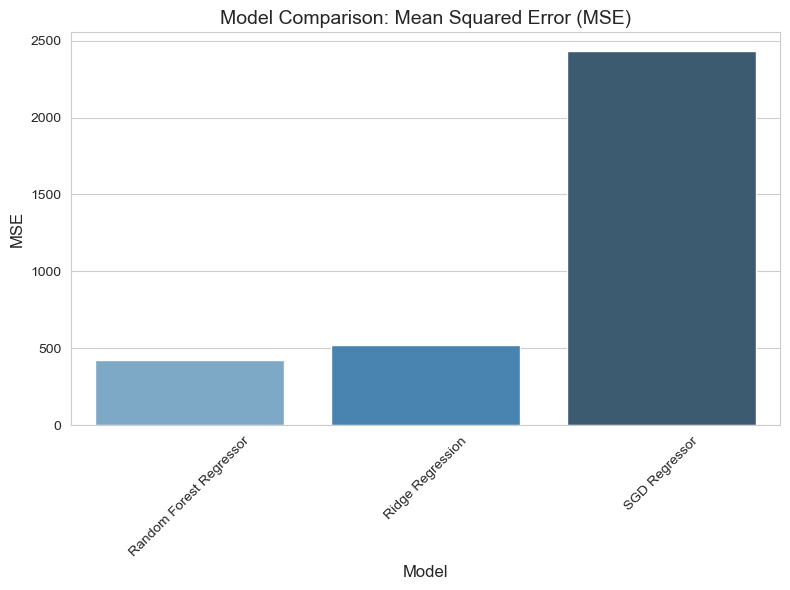

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/3266546636.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='Greens_d')


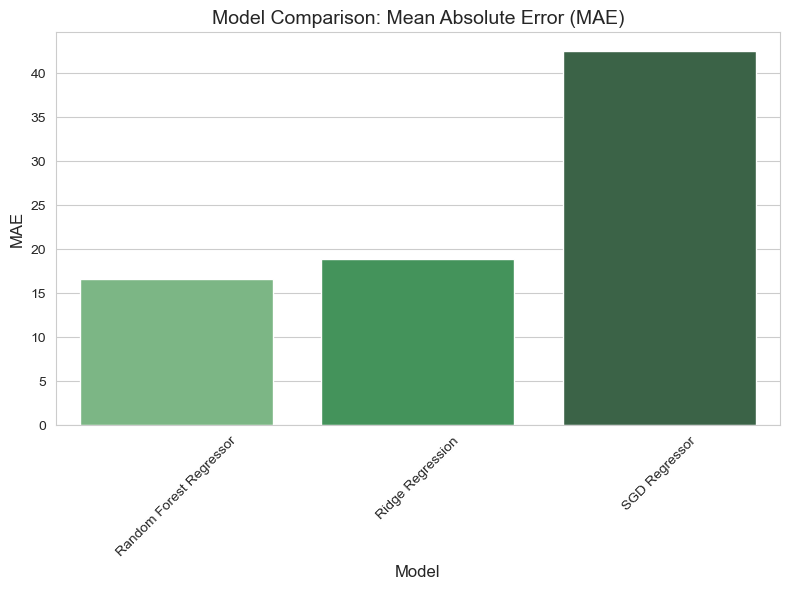

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/3266546636.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=results_df, palette='Reds_d')


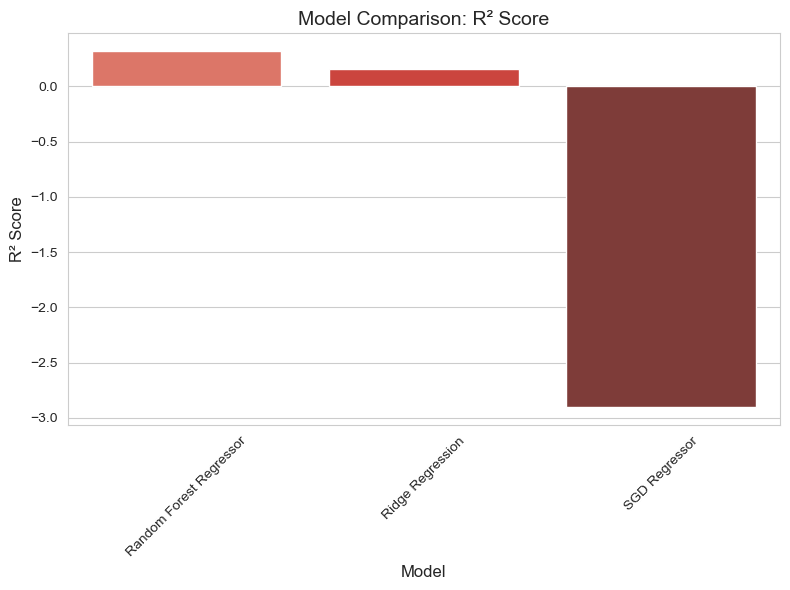

In [93]:
results_df['Model'] = results_df['Model'].astype(str)

sns.set_style("whitegrid")

# Plot MSE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MSE', data=results_df, palette='Blues_d')
plt.title('Model Comparison: Mean Squared Error (MSE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=results_df, palette='Greens_d')
plt.title('Model Comparison: Mean Absolute Error (MAE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R² Score
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R2 Score', data=results_df, palette='Reds_d')
plt.title('Model Comparison: R² Score', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluation

## a) Apply the final model

Our best performing model is the Random Forest Regressor. This model with the above defined hyperparameters achieved a MSE of 423.76 on the validation set. Now, we will use this model to predict on the test set.

In [94]:
test_predictions_rf = best_rf.predict(X_test_transformed)
mse_rf = mean_squared_error(y_test, test_predictions_rf)
mae_rf = mean_absolute_error(y_test, test_predictions_rf)
r2_rf = r2_score(y_test, test_predictions_rf)

final_results = []
final_results.append({
    'Model': "Random Forest Regressor",
    "MSE": mse_rf,
    "MAE": mae_rf,
    "R2 Score": r2_rf
})

print(f"Random Forest Regressor Test Set Performance:")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"R² Score: {r2_rf}")

Random Forest Regressor Test Set Performance:
MSE: 431.92612055783843
MAE: 16.720279795441854
R² Score: 0.30694830876684065


The results are slightly worse than on the validation set, however they are still better than our other tested-out models.

## b) Re-train final model on full train+val set

In [95]:
X_train_val = preprocess_features(X_train_val)
y_train_val = y_train_val.dropna()
X_train_val_transformed = column_transformer.fit_transform(X_train_val)

# fit the best random forest model on the entire train+validation set
best_rf.fit(X_train_val_transformed, y_train_val)

RandomForestRegressor(random_state=42)

In [96]:
test_predictions_rf = best_rf.predict(X_test_transformed)
mse_rf = mean_squared_error(y_test, test_predictions_rf)
mae_rf = mean_absolute_error(y_test, test_predictions_rf)
r2_rf = r2_score(y_test, test_predictions_rf)

final_results.append({
    "Model": "Re-Trained Random Forest Regressor",
    "MSE": mse_rf,
    "MAE": mae_rf,
    "R2 Score": r2_rf
})

print(f"Re-Trained Random Forest Regressor Test Set Performance:")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"R² Score: {r2_rf}")

Re-Trained Random Forest Regressor Test Set Performance:
MSE: 428.54463329509025
MAE: 16.587840251038745
R² Score: 0.3123741104370529


While the result is minimally better, using the full train+validation set to re-train the model does not make a significant difference.

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=final_results_df, palette='Blues_d')


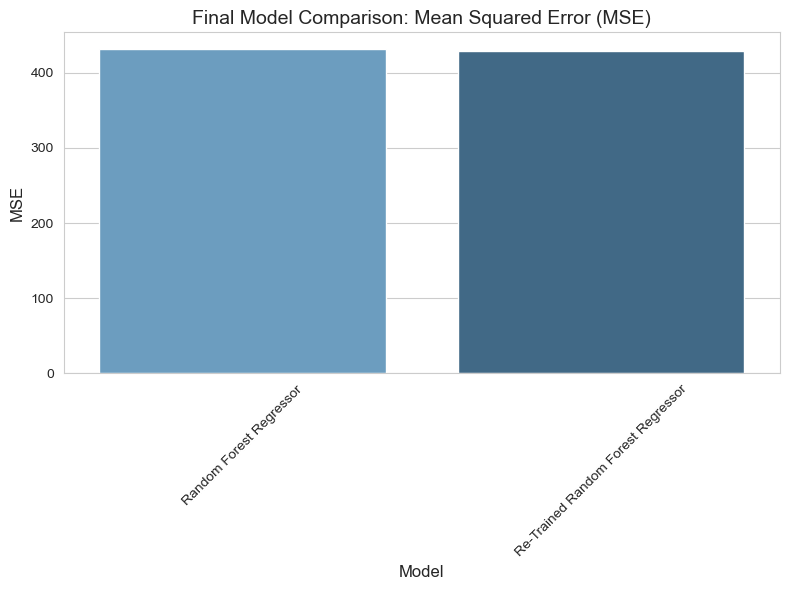

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=final_results_df, palette='Greens_d')


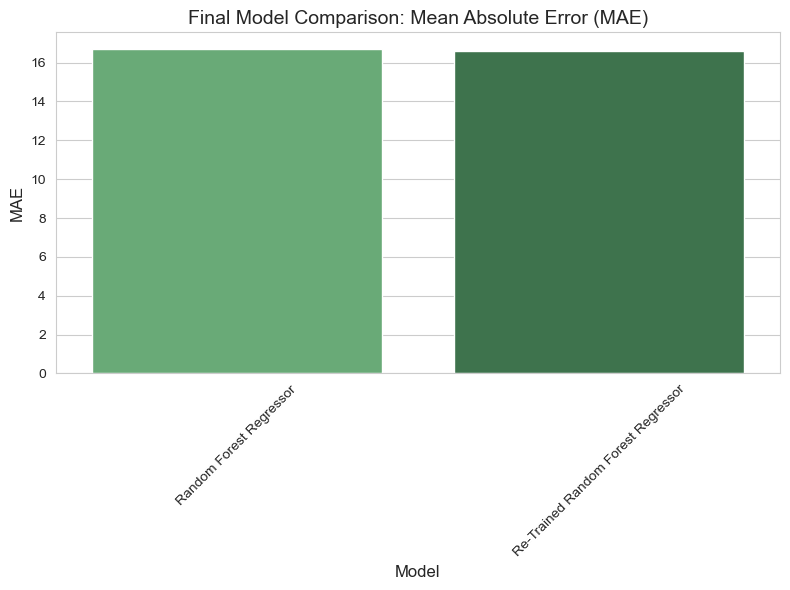

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=final_results_df, palette='Reds_d')


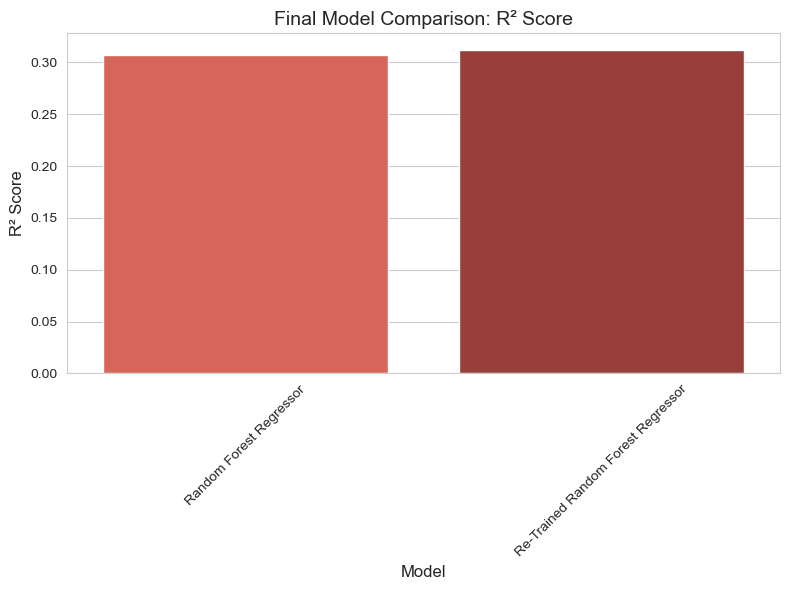

In [97]:
final_results_df = pd.DataFrame(final_results)

sns.set_style("whitegrid")

# Plot MSE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MSE', data=final_results_df, palette='Blues_d')
plt.title('Final Model Comparison: Mean Squared Error (MSE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=final_results_df, palette='Greens_d')
plt.title('Final Model Comparison: Mean Absolute Error (MAE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R² Score
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R2 Score', data=final_results_df, palette='Reds_d')
plt.title('Final Model Comparison: R² Score', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Further model exploration

### Feature importance

In [98]:
best_rf_features = pd.DataFrame(
    best_rf.feature_importances_,
    index=column_transformer.get_feature_names_out(),
    columns=['Importance']
)

best_rf_features = best_rf_features.sort_values(by='Importance', ascending=False)

print("Top 15 Features for Random Forest Regressor:")
print(best_rf_features.head(15))

Top 15 Features for Random Forest Regressor:
                                                     Importance
remainder__album_release_year                          0.110893
remainder__loudness                                    0.080742
remainder__instrumentalness                            0.077507
scale__duration_ms                                     0.073040
remainder__energy                                      0.072164
scale__tempo                                           0.071256
remainder__acousticness                                0.071038
remainder__danceability                                0.067520
remainder__speechiness                                 0.067156
remainder__valence                                     0.066718
remainder__liveness                                    0.063682
remainder__key                                         0.033631
encode__playlist_subgenre_permanent wave               0.015617
encode__playlist_genre_edm                             0.01

In [99]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## c) Baseline Model

### Trivial Baseline using the Mean of Target Variable

In [100]:
# Calculate the mean of the target variable using the full train+val set
mean_popularity = y_train_val.mean()

# Predict the mean for all instances in the test set
test_predictions_trivial = [mean_popularity] * len(y_test)

mse_trivial = mean_squared_error(y_test, test_predictions_trivial)
mae_trivial = mean_absolute_error(y_test, test_predictions_trivial)
r2_trivial = r2_score(y_test, test_predictions_trivial)

final_results.append({
    "Model": "Trivial Baseline (Mean)",
    "MSE": mse_trivial,
    "MAE": mae_trivial,
    "R2 Score": r2_trivial,
})

print(f"Trivial Baseline (Mean) Test Set Performance:")
print(f"MSE: {mse_trivial}")
print(f"MAE: {mae_trivial}")
print(f"R² Score: {r2_trivial}")

Trivial Baseline (Mean) Test Set Performance:
MSE: 623.223535776268
MAE: 20.89043233769664
R² Score: -1.1409852840316148e-08


### Random Classifier Baseline

In [101]:
# Generate random predictions within the range of the target variable
random_predictions = np.random.randint(low=y_train_val.min(), high=y_train_val.max(), size=len(y_test))

mse_random = mean_squared_error(y_test, random_predictions)
mae_random = mean_absolute_error(y_test, random_predictions)
r2_random = r2_score(y_test, random_predictions)

final_results.append({
    "Model": "Random Classifier Baseline",
    "MSE": mse_random,
    "MAE": mae_random,
    "R2 Score": r2_random,
})

print(f"Random Classifier Baseline Test Set Performance:")
print(f"MSE: {mse_random}")
print(f"MAE: {mae_random}")
print(f"R² Score: {r2_random}")

Random Classifier Baseline Test Set Performance:
MSE: 1517.893558702604
MAE: 31.857621440536015
R² Score: -1.4355523963498982


/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MSE', data=final_results_df, palette='Blues_d')


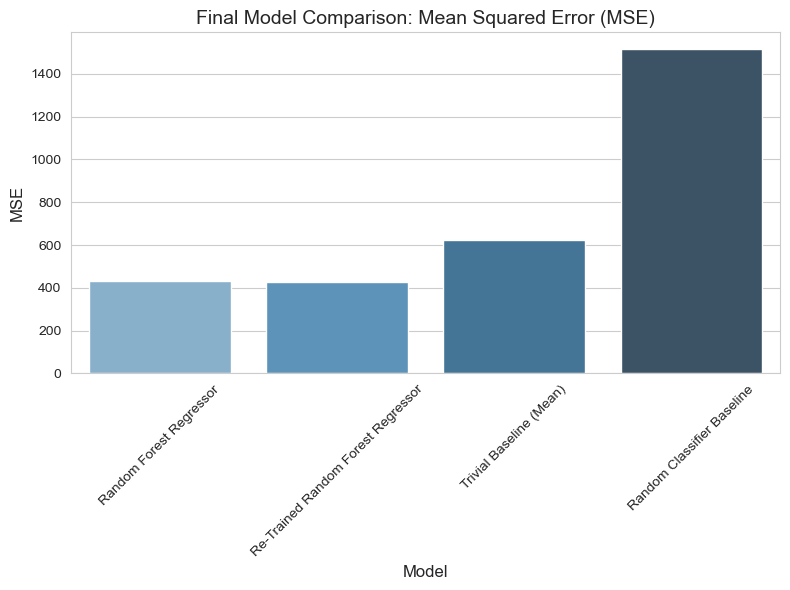

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=final_results_df, palette='Greens_d')


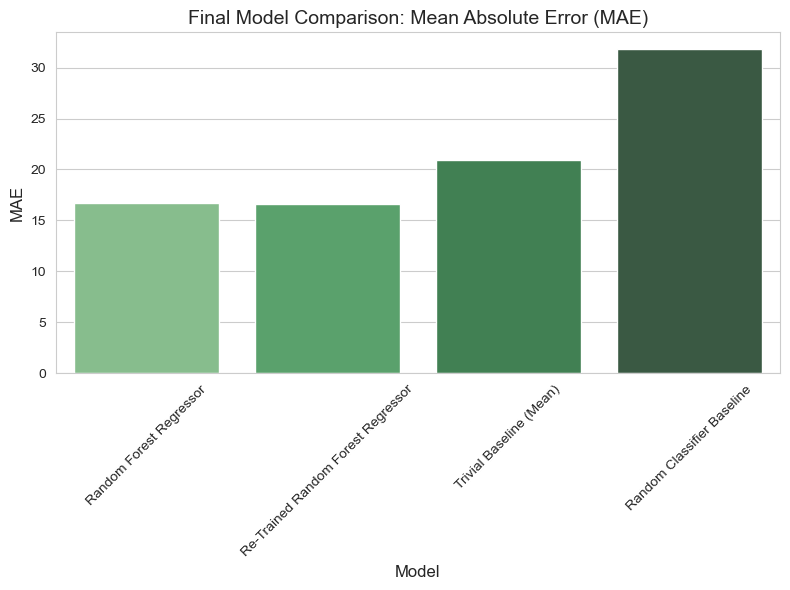

/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/2698401556.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=final_results_df, palette='Reds_d')


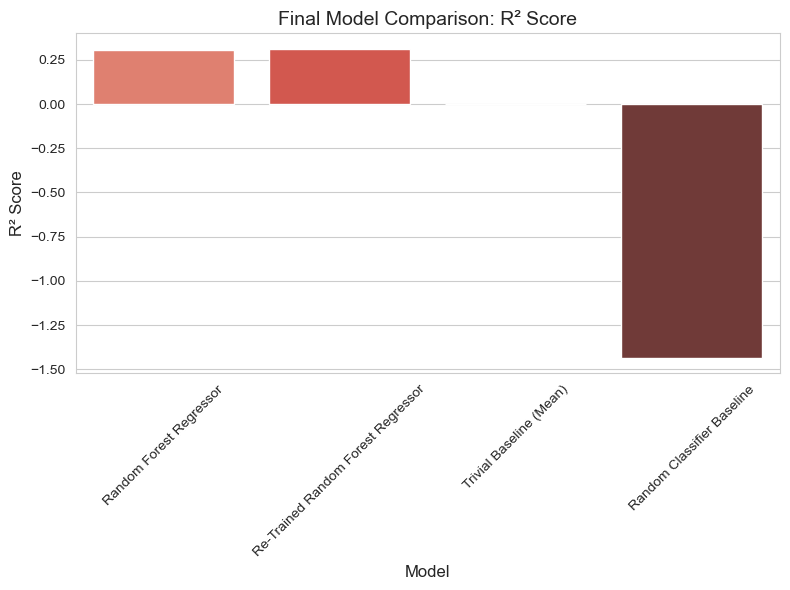

In [102]:
final_results_df = pd.DataFrame(final_results)

sns.set_style("whitegrid")

# Plot MSE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MSE', data=final_results_df, palette='Blues_d')
plt.title('Final Model Comparison: Mean Squared Error (MSE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot MAE
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=final_results_df, palette='Greens_d')
plt.title('Final Model Comparison: Mean Absolute Error (MAE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R² Score
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R2 Score', data=final_results_df, palette='Reds_d')
plt.title('Final Model Comparison: R² Score', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Additional Visualizations for Report (RMSE)

In [103]:
rmse_rf = np.sqrt(mse_rf)
rmse_trivial = np.sqrt(mse_trivial)
rmse_random = np.sqrt(mse_random)
rmse_rf_peker = 14.8
rmse_lr_matt = 26.31

rmse_data = {
    'Model': ['Random Forest Regressor', 'Trivial Baseline', 'Random Classifier', 'Random Forest Peker', 'Linear Regression Matt'],
    'RMSE': [rmse_rf, rmse_trivial, rmse_random, rmse_rf_peker, rmse_lr_matt]
}

rmse_df = pd.DataFrame(rmse_data)
print(rmse_df)

                     Model       RMSE
0  Random Forest Regressor  20.701320
1         Trivial Baseline  24.964445
2        Random Classifier  38.960153
3      Random Forest Peker  14.800000
4   Linear Regression Matt  26.310000


/var/folders/dh/l2p4tzmd4xq1963_484fgqzr0000gn/T/ipykernel_37643/58686181.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='viridis')


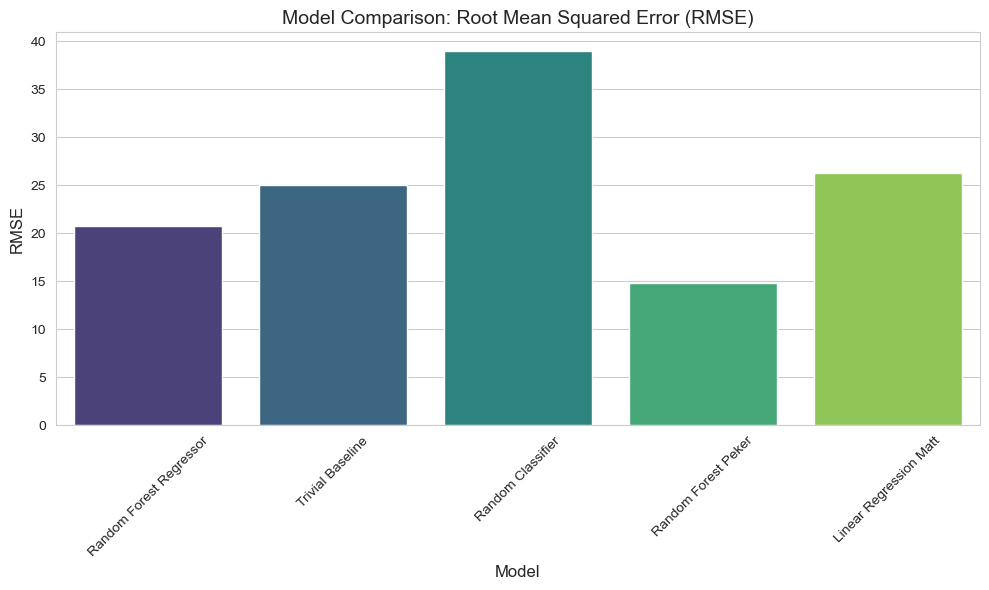

In [104]:
# Plot RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='viridis')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()